# Shapley Tests

## Setup

### Imports

In [1]:
# Type imports
from typing import Any, Dict, Tuple, List

# Standard Libraries
from enum import Enum, auto
from pathlib import Path
from math import sqrt, pi, sin, cos, tan, radians
from statistics import mean

from dataclasses import dataclass, field, asdict
from pprint import pprint

# Shared Packages
import numpy as np
import pandas as pd
import xlwings as xw
import matplotlib.pyplot as plt
#import PySimpleGUI as sg
import pydicom
import shapely
from shapely.plotting import plot_polygon, plot_points

# Local functions and classes
from utilities import *
from types_and_classes import *


### Global Settings

In [2]:
PRECISION = 2


In [3]:
%matplotlib inline

# Metric Functions

## Margins
- $Margin_\perp = bounds(a) − bounds(b)$

- $Margin_{min} = distance(a,b)$

- $Margin_{max} = distance_{housdorff}(a,b)$

**Used By:**
- Contains
- Surrounds
- Shelters (Does not use $Margin_{max}$)


In [4]:
def broadcast_coords(center: np.array, limits: np.array) -> list[np.array]:
    '''Create points at each of the 4 limits, aligned with center_coords.

    Each limit value in limits is placed into an xy pair along with the
    appropriate x or y values from center_coords.

    Args:
        center_coords (np.array): length 2 array of float with center
            coordinates.

    limits (np.array): length 4 array of float with x and y limits.

    precision (int, optional): The number of decimal points to round to.
        Defaults to global PRECISION constant.

Returns:
    list[np.array]: A list of xy coordinate pairs at the specified limits,
        which can form orthogonal lines crossing through the center point.
    '''
    xy_pairs = [None] * 4
    for i in range(2):
        # Start with center coordinates as the xy pairs.
        xy_pairs[i * 2] = center.copy()
        xy_pairs[i * 2 + 1] = center.copy()
        for j in range(2):
            idx = i * 2 + j
            # replace the appropriate x or y value with one of the limits.
            xy_pairs[idx][j] = limits[i][j]
    return xy_pairs

In [5]:
def length_between(line: shapely.LineString,
                   poly_a: Contour, poly_b: Contour)->float:
    '''Calculate the length of the line between poly_a and poly_b.

    Args:
        line (shapely.LineString): A line passing through both poly_a and
            poly_b.
        poly_a (Contour): The outer polygon.
        poly_b (Contour): A polygon contained within poly_a

    Returns:
        float: The length of the line segment that lies between the outside
            of poly_b and the outside of poly_a
    '''
    # disregard any holes in this calculation.
    exterior_a = shapely.Polygon(poly_a.exterior)
    exterior_b = shapely.Polygon(poly_b.exterior)
    # Remove the part of the line inside of poly_b
    line_outside_b = shapely.difference(line, exterior_b)
    # Remove the part of the line outside of poly_a
    line_between_ab = shapely.intersection(line_outside_b, exterior_a)
    return shapely.length(line_between_ab)

In [6]:
def orthogonal_margins(poly_a: Contour, poly_b: Contour,
                       precision: int = PRECISION)->Dict[str, float]:
    '''Calculate the orthogonal margins between poly_a and poly_b.

    The orthogonal margins are the distances between the exterior of poly_b and
    the boundary of poly_a along lines that are parallel to the x and y axes and
    cross the centre point of poly_b.

    Args:
        poly_a (Contour): The outer polygon.
        poly_b (Contour): A polygon contained within poly_a
        precision (int, optional): _description_. Defaults to PRECISION.

    Returns:
        Dict[str, float]: A dictionary containing the orthogonal margins in
            each direction. The keys of the dictionary are:
                ['x_min', 'y_min', 'x_max', 'y_max']
    '''
    # The maximum extent of polygon a in orthogonal directions.
    a_limits = np.array(poly_a.bounds).reshape((2,-1))
    # Coordinates of the centre of polygon b.
    b_center = (shapely.centroid(poly_b))
    center_coords = shapely.get_coordinates(b_center)[0]
    # Points at the maximum extent of a in line with the centre of b.
    end_points = broadcast_coords(center_coords, a_limits)
    orthogonal_lengths = {}
    labels = ['x_min', 'y_min', 'x_max', 'y_max']
    for label, limit_point in zip(labels, end_points):
        # Make a line between the center of b and the limit of a.
        line = shapely.LineString([limit_point, center_coords])
        # Get the length of that line between the edges of b and a.
        length = length_between(line, poly_a, poly_b)
        orthogonal_lengths[label] = round(length, precision)
    return orthogonal_lengths

In [7]:
def min_margin(poly_a: Contour, poly_b: Contour,
               precision: int = PRECISION)->Dict[str, float]:
    boundary_a = poly_a.exterior
    boundary_b = poly_b.exterior
    distance = boundary_a.distance(boundary_b)
    rounded_distance = round(distance, precision)
    return rounded_distance


In [8]:
def max_margin(poly_a: Contour, poly_b: Contour,
               precision: int = PRECISION)->Dict[str, float]:
    boundary_a = poly_a.exterior
    boundary_b = poly_b.exterior
    distance = boundary_a.hausdorff_distance(boundary_b)
    rounded_distance = round(distance, precision)
    return rounded_distance

In [9]:
def margins(poly_a: StructureSlice, poly_b: StructureSlice,
            relation: RelationshipType,
            precision: int = PRECISION)->pd.DataFrame:

    def calculate_margins(polygon_a: Contour, polygon_b: Contour,
                          precision: int = PRECISION)->Dict[str, float]:
        # Only calculate margins when the a polygon contains the b polygon.
        if polygon_a.contains(polygon_b):
            margin_dict = orthogonal_margins(polygon_a, polygon_b, precision)
            margin_dict['max'] = max_margin(polygon_a, polygon_b, precision)
            margin_dict['min'] = min_margin(polygon_a, polygon_b, precision)
            return margin_dict
        return {}

    margin_list = []
    # Compare all polygons on the same slice
    for polygon_a, polygon_b in product(poly_a.contour.geoms,
                                        poly_b.contour.geoms):
        if relation == RelationshipType.CONTAINS:
            margin_dict = calculate_margins(polygon_a, polygon_b, precision)
        elif relation == RelationshipType.SURROUNDS:
            # Compare all holes in each a polygon with each b polygon.
            for hole_ring in polygon_a.interiors:
                hole = shapely.Polygon(hole_ring)
                margin_dict = calculate_margins(hole, polygon_b, precision)
                if margin_dict:
                    margin_list.append(margin_dict)
                margin_dict = {}  # Clear margin_dict so it is not added twice.
        elif relation == RelationshipType.SHELTERS:
            # Get the convex hull for the a polygon.
            hull = shapely.convex_hull(polygon_a)
            margin_dict = calculate_margins(hull, polygon_b, precision)
        if margin_dict:
            margin_list.append(margin_dict)
    if margin_list:
        return pd.DataFrame(margin_list)
    return pd.DataFrame()

### Margin Tests

#### Contains

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Contains</th><th>Transitive</th></tr>
<td class="d" colspan="2">
All points of <span class="b">b</span> lie in the interior of <span class="a">a</span>, no points of <span class="b">b</span> lie in the exterior of <span class="a">a</span>, some points in <span class="a">a</span> are exterior to <span class="b">b</span>, and the boundaries of <span class="a">a</span> and <span class="b">b</span> do not intersect.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/contains simple.png" alt="Contains">
<img src="Images/Relationships/contains with hole.png" alt="Contains With Hole">
</td></tr>
</table></td></tr></table>

In [10]:
def contains_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    a = StructureSlice([circle6])
    b = StructureSlice([circle4])
    return a, b

def contains_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))
    a = StructureSlice([circle6, circle4, circle3])
    b = StructureSlice([circle2])
    return a, b

def contains_example3():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))
    a = StructureSlice([circle6, circle2])
    b = StructureSlice([circle5, circle3])
    return a, b

def contains_example4():
    circle6 = shapely.Polygon(circle_points(3))
    circle3_offset_x = shapely.Polygon(circle_points(1.5, offset_x=1.2))
    a = StructureSlice([circle6])
    b = StructureSlice([circle3_offset_x])
    return a, b

def contains_example5():
    circle6_offset = shapely.Polygon(circle_points(3, offset_y=-1))
    circle3_offset = shapely.Polygon(circle_points(1.5,
                                                     offset_x=0.5,
                                                     offset_y=-2))
    a = StructureSlice([circle6_offset])
    b = StructureSlice([circle3_offset])
    return a, b

def contains_example6():
    circle4_left = shapely.Polygon(circle_points(2, offset_x=-3))
    circle4_right = shapely.Polygon(circle_points(2, offset_x=3))
    circle3_left = shapely.Polygon(circle_points(1.5, offset_x=-3))
    circle3_right = shapely.Polygon(circle_points(1.5, offset_x=3))
    circle5_up = shapely.Polygon(circle_points(2.5, offset_y=4))
    circle2_up = shapely.Polygon(circle_points(1, offset_y=3))
    circle3_down = shapely.Polygon(circle_points(1.5, offset_y=-2.5))
    circle1_down = shapely.Polygon(circle_points(0.5, offset_y=-2))
    a = StructureSlice([circle4_left, circle4_right, circle5_up, circle3_down])
    b = StructureSlice([circle3_left, circle3_right, circle2_up, circle1_down])
    return a, b

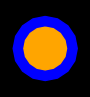

,x_min,y_min,x_max,y_max,max,min
0,1.0,1.0,1.0,1.0,1.0,0.98


In [11]:
a, b = contains_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)


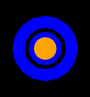

,x_min,y_min,x_max,y_max,max,min
0,0.5,0.5,0.5,0.5,0.51,0.49


In [12]:
a, b = contains_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

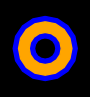

,x_min,y_min,x_max,y_max,max,min
0,0.5,0.5,0.5,0.5,0.5,0.49


In [13]:
a, b = contains_example3()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

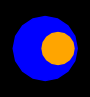

,x_min,y_min,x_max,y_max,max,min
0,2.7,1.24,0.3,1.24,2.7,0.29


In [14]:
a, b = contains_example4()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

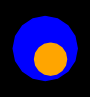

,x_min,y_min,x_max,y_max,max,min
0,1.8,0.4,0.8,2.4,2.61,0.36


In [15]:
a, b = contains_example5()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

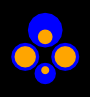

,x_min,y_min,x_max,y_max,max,min
0,0.50,0.5,0.50,0.5,0.5,0.49
1,0.50,0.5,0.50,0.5,0.5,0.49
2,1.28,0.5,1.28,2.5,2.5,0.49
3,0.90,1.5,0.90,0.5,1.5,0.49


In [16]:
a, b = contains_example6()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

#### Surrounds

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Surrounds</th><th>Transitive</t></tr>
<td class="d" colspan="2">
<span class="a">a</span> and <span class="b">b</span> have no interior points in common, and with holes filled <span class="b">b</span> lies in the interior of <span class="a">a</span>.
</td></tr><tr><td colspan="2">
<img src="Images/Relationships/surrounds simple.png" alt="surrounds simple">
<img src="Images/Relationships/surrounds with ring.png" alt="surrounds ring">
</td></tr>
</table></td></tr></table>


In [17]:
def surrounds_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([circle2])
    return a, b

def surrounds_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle5, circle2])
    b = StructureSlice([circle4, circle3])
    return a, b

def surrounds_example3():
    box10x5 = shapely.Polygon(box_points(10,5))
    circle4_left = shapely.Polygon(circle_points(2, offset_x=-3))
    circle3_right = shapely.Polygon(circle_points(1.5, offset_x=3))
    circle2_left = shapely.Polygon(circle_points(1, offset_x=-3, offset_y=0.5))
    circle2_right = shapely.Polygon(circle_points(1, offset_x=3))
    a = StructureSlice([box10x5, circle4_left, circle3_right, circle2_right])
    b = StructureSlice([circle2_left])
    return a, b

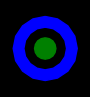

,x_min,y_min,x_max,y_max,max,min
0,1.0,1.0,1.0,1.0,1.0,0.97


In [18]:
a, b = surrounds_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)


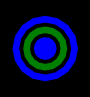

,x_min,y_min,x_max,y_max,max,min
0,0.5,0.5,0.5,0.5,0.51,0.49


In [19]:
a, b = surrounds_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

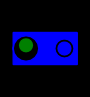

,x_min,y_min,x_max,y_max,max,min
0,0.9,1.5,0.9,0.5,1.5,0.49


In [20]:
a, b = surrounds_example3()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

#### Shelters

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Shelters</th><th>Transitive</th></tr>
<td class="d" colspan="2">
<span class="a">a</span> and <span class="b">b</span> 
have no points in common, 
but the Convex Hull of <span class="a">a</span> contains <span class="b">b</span>.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/shelters.png" alt="Shelters">
</td></tr>
</table></td></tr></table>

In [21]:
def shelters_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle4_offset = shapely.Polygon(circle_points(2, offset_x=3.5))
    shell = shapely.difference(circle6, circle5)
    cove = shapely.difference(shell, circle4_offset)
    circle2 = shapely.Polygon(circle_points(1, offset_x=1))

    a = StructureSlice([cove])
    b = StructureSlice([circle2])
    return a, b


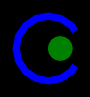

,x_min,y_min,x_max,y_max,max,min
0,3.0,1.8,0.44,1.8,3.0,0.44


In [22]:
a, b = shelters_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

## Distance
- $Distance = distance(a,b)$

**Used By:**
- Disjoint


In [23]:
def distances(poly_a: StructureSlice, poly_b: StructureSlice,
              relation: RelationshipType,
              precision: int = PRECISION)->pd.DataFrame:
    distance_list = []
    # Compare all polygons on the same slice
    for polygon_a, polygon_b in product(poly_a.contour.geoms,
                                        poly_b.contour.geoms):
        boundary_a = polygon_a.exterior
        boundary_b = polygon_b.exterior
        distance = boundary_a.distance(boundary_b)
        rounded_distance = round(distance, precision)
        distance_dict = {'distance': rounded_distance}
        distance_list.append(distance_dict)
    if distance_list:
        return pd.DataFrame(distance_list)
    return pd.DataFrame()

### Distance Tests

#### Disjoint

<link rel="stylesheet" href="relations.css">
<table width="300px">
<tr class="l"><th>Disjoint</th><th>Symmetric</th></tr>
<td class="d" colspan="2">The Convex Hull of 
<span class="a">a</span> has no points in common with <span class="b">b</span>.</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/disjoint.png" alt="Disjoint" style="width: 200px">
</td></tr></table>

In [24]:
def disjoint_example():
    circle4_left = shapely.Polygon(circle_points(4, offset_x=-4.5))
    circle4_right = shapely.Polygon(circle_points(4, offset_x=4.5))

    a = StructureSlice([circle4_left])
    b = StructureSlice([circle4_right])
    return a, b


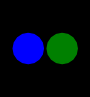

,distance
0,1.0


In [25]:
a, b = disjoint_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
distances(a, b, relation)

# Change labeling:
- Ratio of Areas becomes Ratio of Volumes
- Ratio of Lengths becomes Ratio of Areas



## Ratio of areas

**Used By:**

- Overlaps
> - Ratio of the area of overlap to area of both:
> - $R_a =\frac{2 \times area⁡( a \cap b )}{area⁡( a ) + area⁡( b )}$

- Partition
> - Ratio of the area of overlap to area of the larger shape:
> - $R_a =\frac{area⁡( a \cap b )}{area⁡( a )}$

**Note:** *Must sum all areas first before calculating ratio.*

**Note:** Slice thickness will be the same on the top and bottom, so it will cancel out and Volume / Surface Area ratios can be obtained by summing Areas / Lengths over all slices.


In [26]:
def related_areas(poly_a: StructureSlice, poly_b: StructureSlice)->pd.DataFrame:
    area_list = []
    # Compare all polygons on the same slice
    for polygon_a, polygon_b in product(poly_a.contour.geoms,
                                        poly_b.contour.geoms):
        overlap_region = shapely.intersection(polygon_a, polygon_b)
        area_dict = {'overlap_area': overlap_region.area,
                     'area_a': polygon_a.area,
                     'area_b': polygon_b.area}
        area_list.append(area_dict)
    if area_list:
        return pd.DataFrame(area_list)
    return pd.DataFrame()

In [27]:
def area_ratio(poly_a: StructureSlice, poly_b: StructureSlice,
                  relation: RelationshipType,
                  precision: int = PRECISION)->pd.DataFrame:

    def average_area_ratio(areas: pd.DataFrame,
                           precision: int = PRECISION)->pd.DataFrame:
        total_areas = areas.apply(sum)
        average_area = (total_areas.area_a + total_areas.area_b) / 2.0
        ratio = total_areas.overlap_area / average_area
        rounded_ratio = round(ratio, precision)
        return rounded_ratio

    def larger_area_ratio(areas: pd.DataFrame,
                          precision: int = PRECISION)->pd.DataFrame:
        total_areas = areas.apply(sum)
        ratio = total_areas.overlap_area / total_areas.area_a
        rounded_ratio = round(ratio, precision)
        return rounded_ratio

    areas = related_areas(poly_a, poly_b)
    if relation == RelationshipType.OVERLAPS:
        ratio = average_area_ratio(areas, precision)
    elif relation == RelationshipType.PARTITION:
        ratio = larger_area_ratio(areas, precision)
    else:
        ratio = np.nan
    return ratio

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Overlaps</th><th>Symmetric</th></tr>
<td class="d" colspan="2">
<span class="a">a</span> and <span class="b">b</span> 
have some but not all points in common.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/overlaps simple.png" alt="Overlaps">
<img src="Images/Relationships/overlaps ring.png" alt="Overlaps With Ring">
<img src="Images/Relationships/overlaps surounded.png" alt="Overlaps Surrounded">
<img src="Images/Relationships/overlaps ring surrounds simple.png" alt="Ring Overlaps Simple">
<img src="Images/Relationships/archipelago contains simple.png" alt="Ring Overlaps Simple">
</td></tr></table>

In [28]:
def overlaps_simple_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle6_offset = shapely.Polygon(circle_points(3, offset_x=2))
    box4_offset = shapely.Polygon(box_points(4, offset_x=2))

    a = StructureSlice([circle6])
    b = StructureSlice([circle6_offset])
    return a, b

def overlaps_ring_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle6_offset = shapely.Polygon(circle_points(3, offset_x=2.5))

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([circle6_offset])
    return a, b

def overlaps_surrounded_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1.5, offset_x=1))

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([circle2])
    return a, b

def overlaps_ring_surrounded_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle4 = shapely.Polygon(circle_points(2))

    a = StructureSlice([circle6, circle3])
    b = StructureSlice([circle4])
    return a, b

def overlaps_archipelago_simple_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle4])
    return a, b


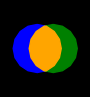

0.58


In [29]:
a, b = overlaps_simple_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(area_ratio(a, b, relation, PRECISION))


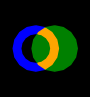

0.29


In [30]:
a, b = overlaps_ring_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(area_ratio(a, b, relation, PRECISION))

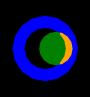

0.11


In [31]:
a, b = overlaps_surrounded_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(area_ratio(a, b, relation, PRECISION))

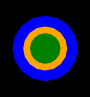

0.32


In [32]:
a, b = overlaps_ring_surrounded_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(area_ratio(a, b, relation, PRECISION))

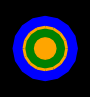

0.14


In [33]:
a, b = overlaps_archipelago_simple_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(area_ratio(a, b, relation, PRECISION))

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Partition</th><th></th></tr>
<td class="d" colspan="2">
The boundaries of <span class="a">a</span> and <span class="b">b</span> have more than one point in common.
No points of <span class="b">b</span> are exterior to <span class="a">a</span>, and some points in <span class="a">a</span> are exterior to <span class="b">b</span>.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/partitions simple.png" alt="Partition">
<img src="Images/Relationships/partitions archipelago with island.png" alt="Partition With Island">
<img src="Images/Relationships/partitions partial ring.png" alt="Partition Ring">
</td></tr></table>

In [34]:
def partition_example1():
    box6 = poly_round(shapely.Polygon(box_points(6)))
    box4_offset = shapely.Polygon(box_points(4, offset_x=-1))
    a = StructureSlice([box6])
    b = StructureSlice([box4_offset])
    return a, b

def partition_example2():
    # Rouding required because pod floating point inaccuracies.
    circle6 = poly_round(shapely.Polygon(circle_points(3)))
    circle4_offset = shapely.Polygon(circle_points(2, offset_x=2))
    cropped_circle = poly_round(shapely.intersection(circle6, circle4_offset))
    a = StructureSlice([circle6])
    b = StructureSlice([cropped_circle])
    return a, b

def partition_example3():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))
    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle2])
    return a, b

def partition_example4():
    # Rouding required because pod floating point inaccuracies.
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    box6_offset = shapely.Polygon(box_points(6, offset_x=2))
    ring = shapely.difference(circle6, circle4)
    cropped_ring = poly_round(shapely.difference(ring, box6_offset),PRECISION)
    a = StructureSlice([circle6, circle4])
    b = StructureSlice([cropped_ring])
    return a, b

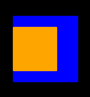

0.44


In [35]:
a, b = partition_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(area_ratio(a, b, relation, PRECISION))

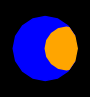

0.33


In [36]:
a, b = partition_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(area_ratio(a, b, relation, PRECISION))

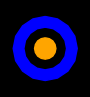

0.17


In [37]:
a, b = partition_example3()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(area_ratio(a, b, relation, PRECISION))

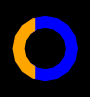

0.37


In [38]:
a, b = partition_example4()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(area_ratio(a, b, relation, PRECISION))

## Ratio of lengths

**Used By:**

- Exterior Borders
> - Ratio of the length of overlap to the length of the exterior perimeter.
> - $R_l = \frac{2 \times l⁡(a_p \cap b_p)}{ l(a_{px}) + l(b_{px})}$

- Interior Borders
> - Ratio of the length of overlap to the length of the exterior perimeter.
> - $R_l = \frac{l⁡(a_p \cap b_p)}{l(a_{ph}) + l(b_{px})}$

Where:
- $a_p$ is the perimeter of polygon $a$
- $b_p$ is the perimeter of polygon $b$
- $a_{px}$ is the exterior perimeter of polygon $a$
- $b_{px}$ is the exterior perimeter of polygon $b$
- $a_{ph}$ is the perimeter of the relevant hole within polygon $a$
- $l⁡(p_i)$ is the length of perimeter $i$

**Note:** *Must sum all lengths first before calculating ratio.*


# Done To Here

# Fix Accumulated lengths
- Entire surface area is needed not just on slices with second contour.
- Only want to include surface area of holes containing second contour.

**? How to determine when to add perimeter?**

In [ ]:
def related_lengths(poly_a: StructureSlice,
                    poly_b: StructureSlice)->List[shapely.LineString]:
    perimeter_list = []
    # Compare all polygons on the same slice
    for polygon_a, polygon_b in product(poly_a.contour.geoms,
                                        poly_b.contour.geoms):
        exterior_a = polygon_a.exterior
        exterior_b = polygon_b.exterior
        overlap_region = shapely.shared_paths(exterior_a, exterior_b)
        if overlap_region:
            perimeter_dict = {'overlapping_perimeter': overlap_region,
                              'perimeter_a': exterior_a,
                              'perimeter_b': exterior_b}
            perimeter_list.append(perimeter_dict)
        for hole_ring in polygon_a.interiors:
            hole = shapely.Polygon(hole_ring)
            hole_perimeters = related_lengths(hole, polygon_b)
            if hole_perimeters:
                perimeter_list.extend(hole_perimeters)
    return perimeter_list


In [ ]:
def length_ratio(poly_a: StructureSlice, poly_b: StructureSlice,
                 relation: RelationshipType,
                 precision: int = PRECISION)->pd.DataFrame:

    def get_length(perimeter: shapely.LineString)->float:
        return shapely.length(perimeter)

    perimeter_list = related_lengths(poly_a, poly_b)
    if not perimeter_list:
        return np.nan
    perimeters = pd.DataFrame(perimeter_list)
    lengths = perimeters.apply(get_length)
    lengths_sum = lengths.apply(sum)
    total_lengths = lengths_sum.perimeter_a + lengths_sum.perimeter_b
    ratio = lengths_sum.overlapping_perimeter / total_lengths
    rounded_ratio = round(ratio, precision)
    return rounded_ratio

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Borders</th><th>Symmetric</th></tr>
<td class="d" colspan="2">The exterior boundaries of 
<span class="a">a</span> and <span class="b">b</span> 
have more than one point in common, but their interiors do not intersect.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/borders.png" alt="Borders">
<img src="Images/Relationships/Concave Borders.png" alt="Concave Borders">
</tr></table>

In [25]:
def borders_example1():
    box4_left = shapely.Polygon(box_points(4, offset_x=-2))
    box4_right = shapely.Polygon(box_points(4, offset_x=2))

    a = StructureSlice([box4_left])
    b = StructureSlice([box4_right])
    return a, b

def borders_example2():
    box6 = shapely.Polygon(box_points(6))
    box5_up = shapely.Polygon(box_points(5, offset_y=3))
    box6_cropped = shapely.difference(box6, box5_up)

    a = StructureSlice([box6_cropped])
    b = StructureSlice([box5_up])
    return a, b

In [26]:
a, b = borders_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))

In [27]:
a, b = borders_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))

<link rel="stylesheet" href="relations.css">
<table width="300px">
<tr class="l"><th>Borders_Interior</th><th>Symmetric</th></tr>
<td class="d" colspan="2">The interior boundary of <span class="a">a</span> 
and the exterior boundary of <span class="b">b</span> 
have more than one point in common, but their interiors do not intersect.
<tr><td colspan="2">
<img src="Images/Relationships/confines.png" alt="Borders Interior">
<img src="Images/Relationships/confines with island.png" alt="Borders Interior With Island">
</td></tr></table>

In [28]:
def interior_borders_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    box4_offset = shapely.Polygon(box_points(4, offset_x=2))
    cropped_circle = shapely.difference(circle4, box4_offset)

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([cropped_circle])
    return a, b

def interior_borders_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle4, circle2])
    return a, b

def interior_borders_example3():
    # 6 cm x 6 cm box with 4cm x 4 cm hole
    box6 = shapely.Polygon(box_points(6))
    box4 = shapely.Polygon(box_points(4))
    a = StructureSlice([box6, box4])
    b = StructureSlice([box4])
    return a, b

In [29]:
a, b = interior_borders_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))

In [30]:
a, b = interior_borders_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))

In [31]:
a, b = interior_borders_example3()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Equals</th><th>Symmetric, Transitive</th></tr>
<td class="d" colspan="2">
The interiors of <span class="a">a</span> and <span class="b">b</span> 
intersect and no part of the interior of one geometry intersects the exterior of the other.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/equals.png" alt="Equals">
</td></tr></table>

In [43]:
def equals_example1():
    box6 = shapely.Polygon(box_points(6))
    a = StructureSlice([box6])
    b = StructureSlice([box6])
    return a, b

def equals_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    cropped_circle = shapely.intersection(circle6, circle5)
    a = StructureSlice([circle5])
    b = StructureSlice([cropped_circle])
    return a, b


In [44]:
a, b = equals_example1()


In [45]:
a, b = equals_example2()
